In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10,8]

# generate data to work with

In [2]:
numSteps = 7
constLen = 30
rampLen = 4

## generate current data

In [61]:
startingI = 20
stepsizeI = startingI / float(numSteps)
noiseAmpI = .1

idata = np.array([])

for i in range(numSteps):
    idata = np.append(idata,
                      (startingI - i * stepsizeI)
                      + np.random.normal(scale=noiseAmpI, size=constLen)
                     )  # append constant I part
    
    idata = np.append(idata,
                      np.linspace(startingI - i * stepsizeI, startingI - (i+1) * stepsizeI, num=rampLen)
                      + np.random.normal(scale=noiseAmpI, size=rampLen)
                     )  # append linear I decrease part

dfi = pd.DataFrame(idata)

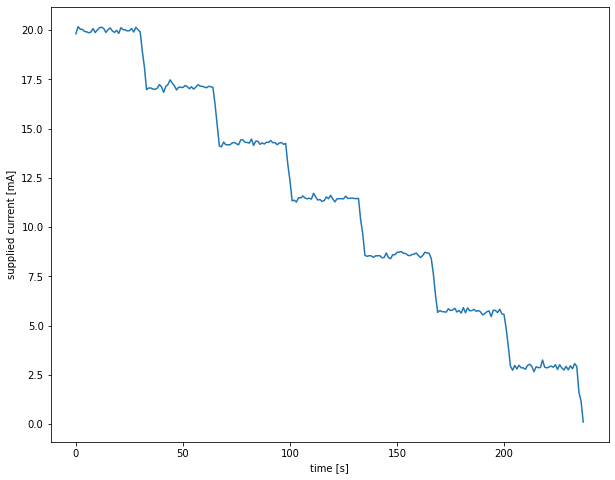

In [62]:
plt.plot(idata)
plt.xlabel('time [s]')
plt.ylabel('supplied current [mA]')
plt.show()

## generate voltage data

In [63]:
startingV = 7
prevlevel = startingV
initstepsizeV = startingV / float(numSteps)
noiseAmpV = .03
vdata = np.array([])

for i in range(numSteps):
    dyn_stepsize = (numSteps - i)/float(numSteps) * initstepsizeV
    vdata = np.append(vdata,
                      prevlevel
                      + np.random.normal(scale=noiseAmpV, size=constLen)
                     )  # append constant V part
    
    vdata = np.append(vdata,
                      np.linspace(prevlevel, prevlevel - dyn_stepsize, num=rampLen)
                      + np.random.normal(scale=noiseAmpV, size=rampLen)
                     )  # append linear V decrease part
    
    prevlevel = prevlevel - dyn_stepsize  # results in non-linear IV curve

dfv = pd.DataFrame(vdata)

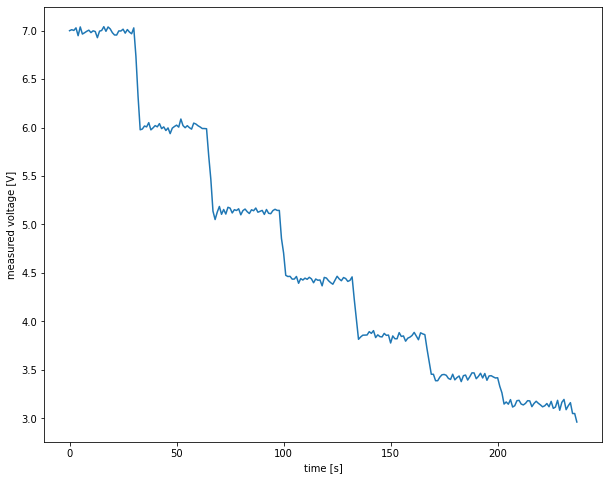

In [64]:
plt.plot(vdata)
plt.xlabel('time [s]')
plt.ylabel('measured voltage [V]')
plt.show()

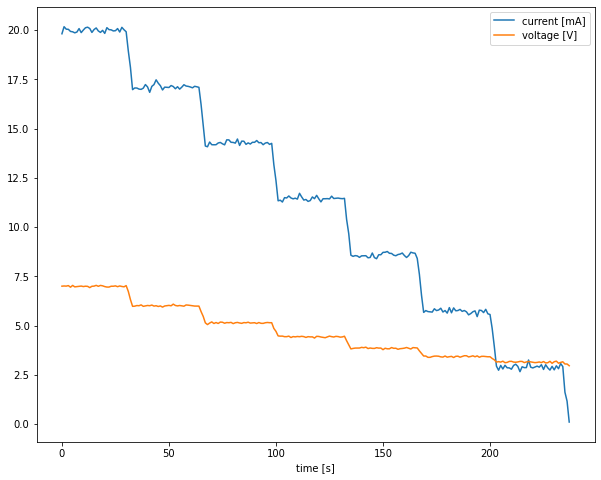

In [65]:
plt.plot(idata)
plt.plot(vdata)
plt.xlabel('time [s]')
plt.legend(['current [mA]', 'voltage [V]'])
plt.show()

# data smoothing functions

Useful to do so that changepoint detection might work better, at least in current implementation of finding areas where delta is large.

In [22]:
def moving_average(data, n=3, pad_data=False):
    out = np.cumsum(data, dtype=float)
    out[n:] = out[n:] - out[:-n]
    
    out = out[n-1:] / n
    
    if pad_data:  # if want output to have same shape as input, preappend data (useful for preserving time info)
        out = np.append(out[0] * np.ones(n-1), out)
    
    return out

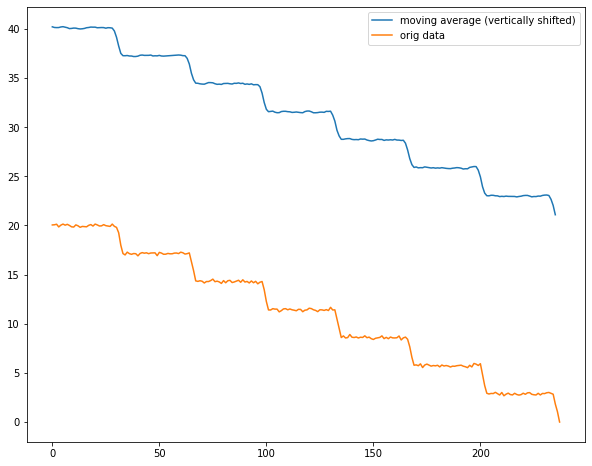

In [40]:
plt.plot(moving_average(idata) + max(idata))
plt.plot(idata)
plt.legend(['moving average (vertically shifted)', 'orig data'])
plt.show()

# generate IV curve

First I'll do it with the numpy arrays for simplicity, then I should move on to doing it with the pandas DataFrames.

In [10]:
def detectEndConst(data, threshold, showPlots=False):
    delta = np.diff(data)  # delta[i] = data[i+1] - data[i]
    indicators = (np.abs(delta) > threshold).astype(int)
    
    delta_indic = np.diff(indicators)  # endpoints will be locations (with offset) where delta_indic = 1
    end_locs = np.argwhere(delta_indic == 1).flatten() + 1
        
    if showPlots:
        plt.plot(data)
        plt.plot(delta)
        plt.plot(indicators)
        plt.plot(delta_indic)
        plt.legend(['data', 'delta', 'indicators', 'delta_indic'])
        plt.vlines(x = end_locs, ymin = 0, ymax = max(data),
           colors = 'black')
        plt.show()
    
    return end_locs

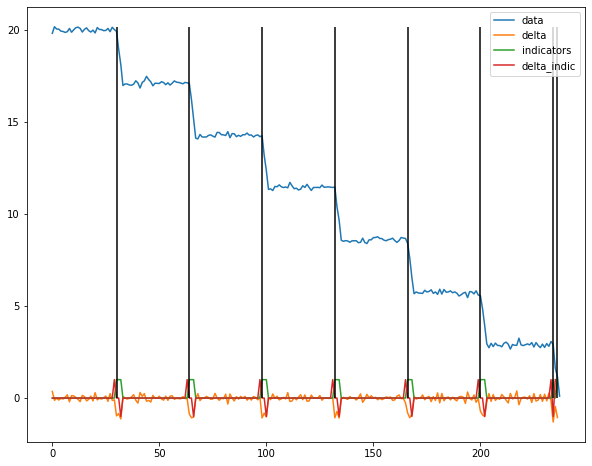

array([ 30,  64,  98, 132, 166, 200, 234, 236], dtype=int64)

In [66]:
detectEndConst(idata, .5, showPlots=True)

Lesson: if rate at which we ramp down current is too slow compared to noise amplitude, it's hard to threshold in a reliable way. Might need to denoise the data first (e.g. moving average) before passing into <code>detectEndConst</code>. For now I'll ensure we ramp quickly enough.

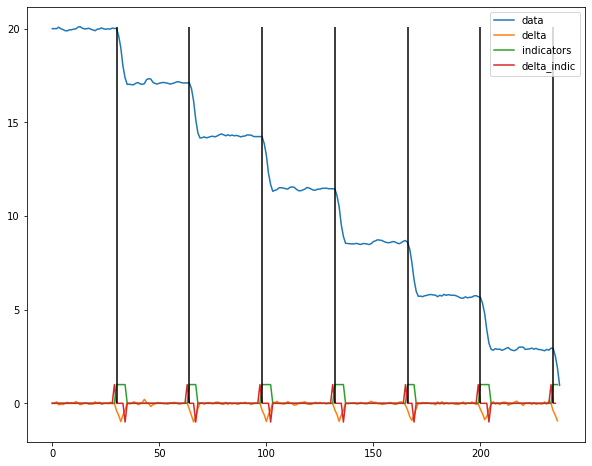

array([ 30,  64,  98, 132, 166, 200, 234], dtype=int64)

In [67]:
detectEndConst(moving_average(idata, n=3, pad_data=True), .3, showPlots=True)

In [68]:
def getIV(idata, vdata, threshold, lag=0, smoothFN=lambda x: x):
    vdata = smoothFN(vdata)
    idata = smoothFN(idata)
    
    sample_points = detectEndConst(idata, threshold) - lag
    x = vdata[sample_points]
    y = idata[sample_points]
    
    plt.plot(x, y, '-o')
    plt.xlabel('voltage [V]')
    plt.ylabel('current [mA]')
    plt.show()

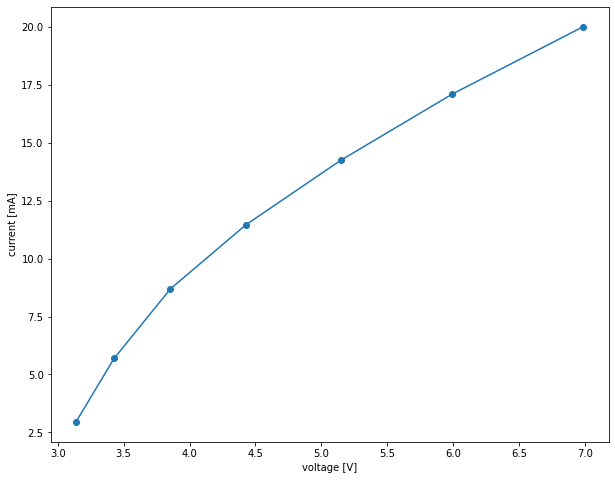

In [70]:
getIV(idata, vdata, .5, smoothFN=moving_average, lag=2)